# PreviousOne

Trains model on synthetic data .

In [1]:
import sys
sys.path.append('../..')


In [2]:
from numpy import ones, convolve, ndarray, maximum, concatenate, apply_along_axis, mean
from tqdm import tqdm
from model_compra_comigo.data_handler import DataSimulator
from model_compra_comigo.data_handler import DataHandler
import tensorflow as tf
from numpy import arange
import numpy as np
import tensorflow_datasets as tfds
import gc


2023-07-26 23:24:44.859561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 23:24:45.354013: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 23:24:45.355455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 23:24:47.671929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
data_simulator = DataSimulator()
data_handler = DataHandler()


## Generate a Dataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


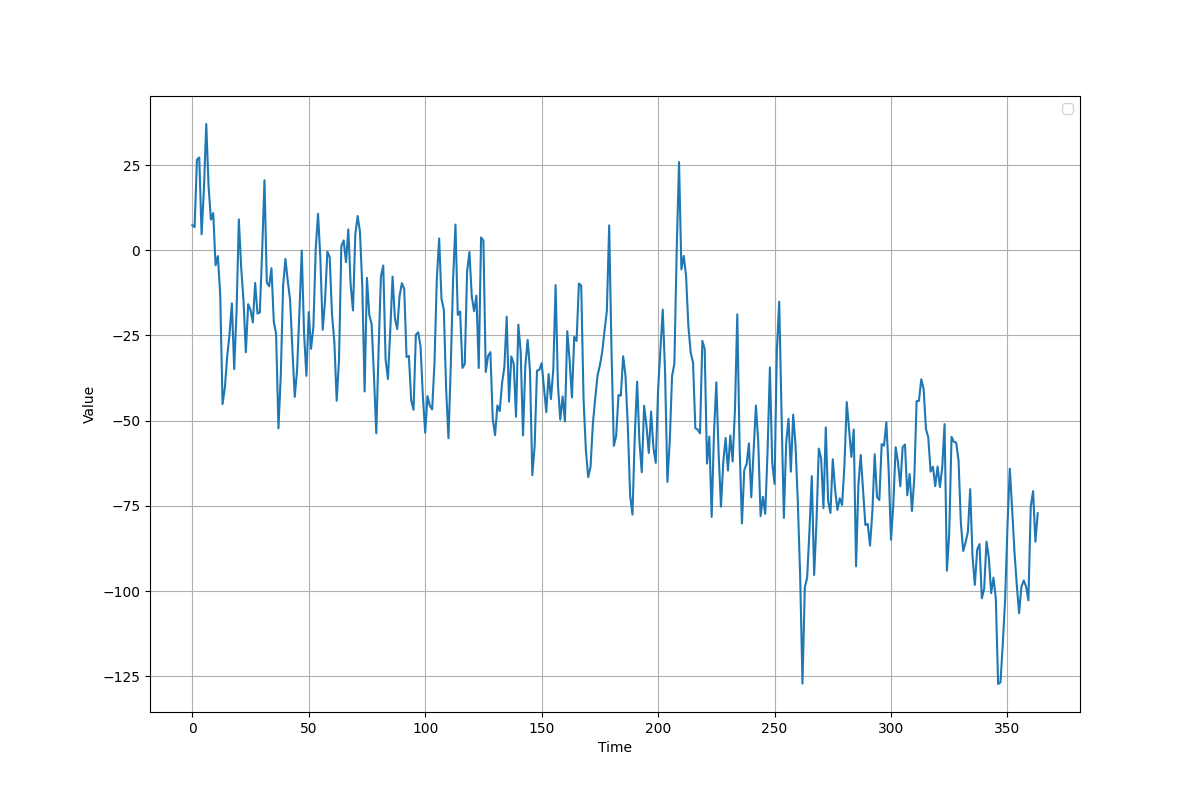

In [4]:
time_range = 365
time_data = arange(time_range)

series, parameters = data_simulator.generate(
    time_range = time_range,
)

labels=[(f"trend_slope = {parameters['trend_slope']}\n"
         f"seasonality_period = {parameters['seasonality_period']}\n"
         f"seasonality_amplitude = {parameters['seasonality_amplitude']}\n"
         f"seasonality_phase = {parameters['seasonality_phase']}\n"
         f"seasonality_time_threshold = {parameters['seasonality_time_threshold']}\n"
         f"seasonality_ncos = {parameters['seasonality_ncos']}\n"
         f"seasonality_nexp = {parameters['seasonality_nexp']}\n"
         f"noise_scaling_factor = {parameters['noise_scaling_factor']}\n"
         f"autocorrelation_amplitude = {parameters['autocorrelation_amplitude']}\n"
         f"autocorrelation_phi = {parameters['autocorrelation_phi']}"
        )]

image = data_handler.plot_series(
    time=time_data,
    series=series,
    labels=labels
)

image

# Trains and tests some models
Experimentation

In [5]:
window_size = 40
nforecast = 30
batch_size = 26
shuffle_buffer_size = 10000

## Naive Models


### Previous One
Naive "Model" using only Previous One (used as a possible baseline model to compare the performance of others)

In [6]:
from model_compra_comigo.model import PreviousOneModel


In [7]:
model = PreviousOneModel()


### Creates data for evaluation and for prediction

#### Data for evaluation

In [8]:
data = data_handler.generate_windowed_dataset(
    data = series,
    window_size = window_size,
    batch_size = batch_size,
    shuffle_buffer_size = shuffle_buffer_size,
    nforecast = nforecast
)


#### Data for prediction

In [9]:
data_f = data_handler.generate_windowed_data_forecast(
    data = series,
    window_size = window_size,
    batch_size = batch_size,
)

### Predict

In [10]:
prediction = model.predict_batch(
    data=data_f,
    window_size=window_size,
    nforecast=nforecast
)
prediction.shape

2023-07-26 23:24:56.759654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [365]
	 [[{{node Placeholder/_0}}]]
2023-07-26 23:24:56.764268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [365]
	 [[{{node Placeholder/_0}}]]


(326, 30)

In [11]:
import pandas as pd
pd.DataFrame(prediction)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,...,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927,-10.438927
1,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,...,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177,-2.570177
2,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,...,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032,-9.086032
3,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,...,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783,-14.503783
4,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,...,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537,-29.347537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,...,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827,-75.243827
322,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,...,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531,-70.658531
323,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,...,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052,-85.509052
324,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,...,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106,-77.153106


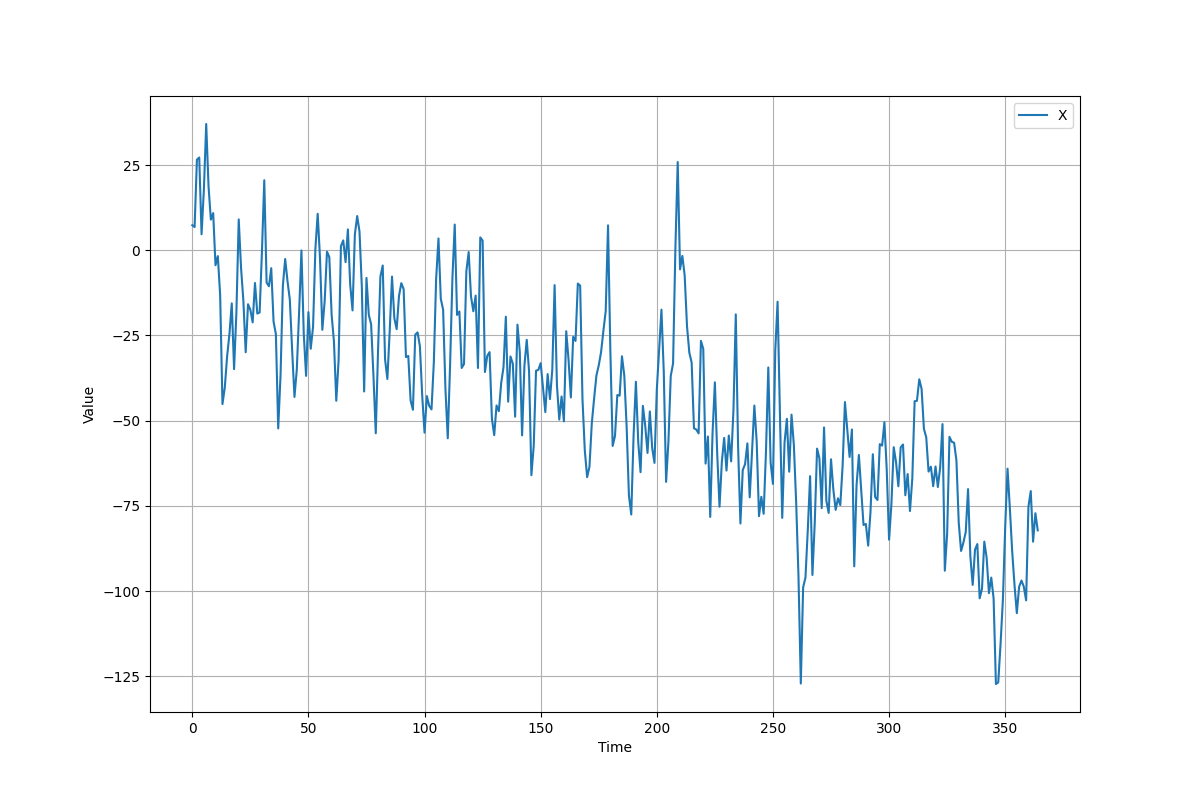

In [12]:
image = data_handler.plot_all(
    series_lines = [(time_data, series)],
    labels_lines = ["X"],
    labels_points = ["prediction"],
    xy_label = ["Time", "Value"],
)
image

In [13]:
data_np = data_handler.convert_tensorflow_dataset_to_numpy(data_f)


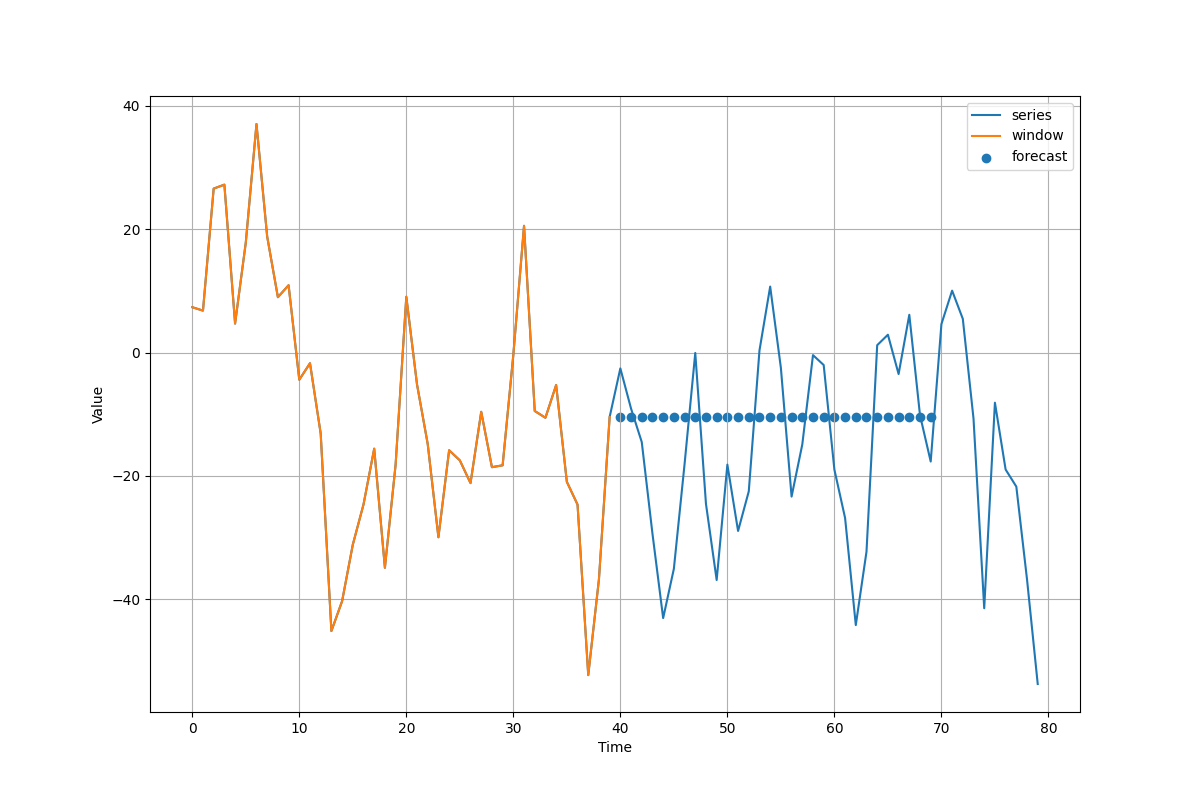

In [14]:
data_handler.plot_all(
    series_lines = [
                    (time_data[:80], series[:80]),
                    (time_data[:window_size], data_np[0][0]),
                   ],
    series_points = [(time_data[window_size:window_size+nforecast], prediction[0])],
    labels_lines = ["series", "window"],
    labels_points = ["forecast"],
    xy_label = ["Time", "Value"],
)

In [15]:
model.evaluate(
    data=data,
    window_size=window_size,
    nforecast=nforecast
)

2023-07-26 23:25:03.329910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [365]
	 [[{{node Placeholder/_0}}]]
2023-07-26 23:25:03.330368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [365]
	 [[{{node Placeholder/_0}}]]


{'mse': 666.3867012278196, 'mae': 20.30715922726061}

In [16]:
plots = []

for i, example in enumerate(tqdm(data_f)):
    forecast = apply_along_axis(
        func1d=model.predict,
        axis=-1,
        arr=example.numpy(),
        nforecast=nforecast
    )
    n = forecast.shape[0]
    for j in tqdm(range(0, n)):
        ind = i*batch_size+j
        X = list(time_data[np.minimum(window_size+ind, len(time_data)):np.minimum(window_size+nforecast+ind, len(time_data))])
        if not X:
            X = [time_data[-1]+1]
        if len(X) < nforecast:
            X = X + list(range(X[-1]+1, X[-1]+nforecast+1-len(X)))
        plot = data_handler.plot_all(
            series_lines = [
                            (time_data[np.maximum(0,ind-70):70+ind], series[np.maximum(0,ind-70):70+ind]),
                            (time_data[ind:window_size+ind], data_np[j][i]),
                           ],
            series_points = [(X, forecast[j])],
            labels_lines = ["series", "window"],
            labels_points = ["forecast"],
            xy_label = ["Time", "Value"],
        )
        plots.append(plot)
    gc.collect()
plots[0].save('./tmp/previous_one.gif',
             save_all = True, append_images = plots[1:], 
             optimize = False, duration = 100)

In [19]:
from model_compra_comigo.data_handler import Visualizer

visualizer = Visualizer()

In [21]:
plots = visualizer.create_gif(
    time_data=time_data,
    series=series,
    forecast=prediction,
    batch_size=batch_size,
    window_size=window_size,
    nforecast=nforecast,
    gif_window=70,
)
plots[0].save('./tmp/previous_one_2.gif',
             save_all = True, append_images = plots[1:], 
             optimize = False, duration = 100)

TypeError: create_gif() got an unexpected keyword argument 'generate_full_visualization'

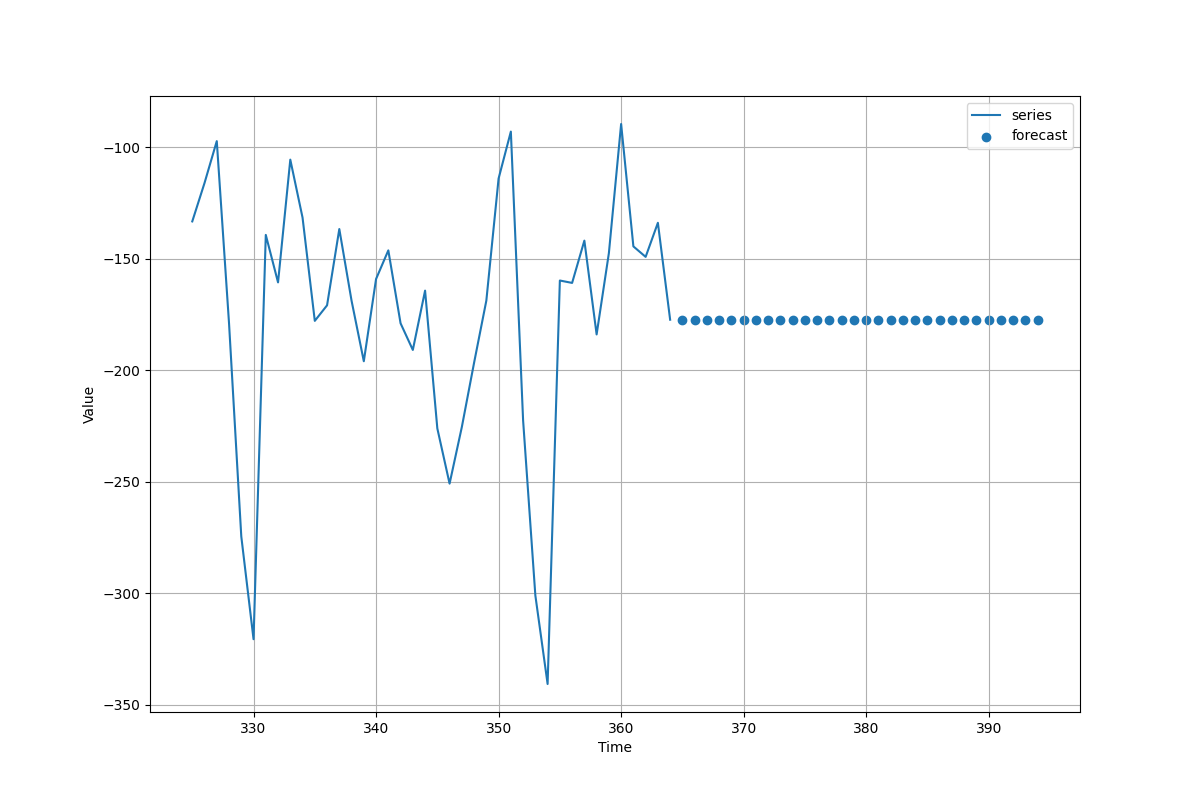

In [70]:
plot = DataHandler.plot_all(
    series_lines=[
        (time_data[-window_size:], series[-window_size:]),
    ],
    series_points=[(new_pts, prediction[-1])],
    labels_lines=["series", "window"],
    labels_points=["forecast"],
    xy_label=["Time", "Value"],
)
plot